In [1]:
import sys

sys.path.append("../..")
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_from_disk
from omegaconf import OmegaConf
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer

from src.hyperdas.data_utils import (
    get_ravel_collate_fn,
)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataset = load_from_disk("./data/city_train")
test_dataset = load_from_disk("./data/city_test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model_path = (
    "/workspace/HyperDAS/assets/checkpoints/QuasiProjective_20241105_031206/final_model"
)

In [5]:
cfg = OmegaConf.load(os.path.join(model_path, "config.yaml"))
cfg.model.inference_modes = ["groundtruth"]

In [6]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(config=cfg, device="cuda")
hypernetwork.load_model(model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
DEBUG:src.hyperdas.llama3.modules:Initializing LlamaInterpretorHypernetwork
DEBUG:src.hyperdas.llama3.modules:Loading pretrained model for LlamaModelWithCrossAttention


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:src.hyperdas.llama3.modules:Loading cached LlamaInterpretorHypernetwork...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
test_dataset = [d for d in test_dataset if d["attribute_type"] == "causal"]
train_dataset = [d for d in train_dataset if d["attribute_type"] == "causal"]

In [8]:
collate_fn = get_ravel_collate_fn(
    tokenizer,
    source_suffix_visibility=cfg.dataset.source_suffix_visibility,
    base_suffix_visibility=cfg.dataset.base_suffix_visibility,
    add_space_before_target=True,
    contain_entity_position="groundtruth" in cfg.model.inference_modes,
)
dataloader = DataLoader(
    test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False
)

inference_mode = cfg.model.inference_modes[0]

hypernetwork.interpretor.eval()
test_loss = []
correct_idxs = []
is_causal = []
attributes = []
basis_dataset = []

curr_idx = 0

with torch.no_grad():
    for batch_id, batch in enumerate(tqdm(dataloader)):
        example_idxs = range(curr_idx, curr_idx + len(batch["editor_input_ids"]))
        curr_idx += len(batch["editor_input_ids"])

        if curr_idx >= len(train_dataset):
            break

        corresponding_attribute = [test_dataset[i]["attribute"] for i in example_idxs]
        attributes.extend(corresponding_attribute)

        # Move entire batch to GPU once
        batch = {k: v.to("cuda") for k, v in batch.items()}

        if inference_mode == "groundtruth":
            intervention_weight = torch.zeros(
                len(batch["editor_input_ids"]),
                batch["source_input_ids"].shape[1] + 1,
                batch["base_input_ids"].shape[1],
                device=batch["editor_input_ids"].device,
            )
            intervention_weight[:, -1, :] = 1.0

            for i in range(len(batch["base_entity_position_ids"])):
                intervention_weight[i, -1, batch["base_entity_position_ids"][i]] = 0.0
                intervention_weight[
                    i,
                    batch["source_entity_position_ids"][i],
                    batch["base_entity_position_ids"][i],
                ] = 1.0
        else:
            intervention_weight = None

        predictions = hypernetwork.forward(
            editor_input_ids=batch["editor_input_ids"],
            base_input_ids=batch["base_input_ids"],
            base_attention_mask=batch["base_attention_mask"],
            base_intervention_mask=batch["base_intervention_mask"],
            source_input_ids=batch["source_input_ids"],
            source_attention_mask=batch["source_attention_mask"],
            source_intervention_mask=batch["source_intervention_mask"],
            labels=batch["labels"],
            inference_mode="groundtruth",
            intervention_weight=intervention_weight,
            return_basis=True,
        )
        test_loss.append(predictions["loss"].item())

        basis = next(iter(predictions["basis"].values()))
        basis_dataset.append(basis)

        batch_pred_ids = torch.argmax(predictions["logits"], dim=-1)
        is_causal.extend(batch["is_causal"].cpu().numpy().tolist())

        for i, (label, pred_ids) in enumerate(zip(batch["labels"], batch_pred_ids)):
            label_idx = label != -100
            output_idx = torch.zeros_like(label_idx)
            output_idx[:-1] = label_idx[1:]

            label = label[label_idx]
            pred_ids = pred_ids[output_idx]

            is_correct = (torch.sum(label == pred_ids) == torch.numel(label)).item()
            if is_correct:
                correct_idxs.append(batch_id * len(batch["labels"]) + i)


total_causal = sum(is_causal)
total_isolate = len(is_causal) - total_causal

correct_causal = sum([is_causal[i] for i in correct_idxs])
correct_isolate = len(correct_idxs) - correct_causal

causal_acc = correct_causal / total_causal if total_causal > 0 else 0.0
isolate_acc = correct_isolate / total_isolate if total_isolate > 0 else 0.0
disentangle_acc = 0.5 * (causal_acc + isolate_acc)

accuracies = {
    "causal": causal_acc,
    "isolate": isolate_acc,
    "disentangle": disentangle_acc,
}

  0%|          | 0/439 [00:00<?, ?it/s]

100%|██████████| 439/439 [02:35<00:00,  2.83it/s]


In [9]:
accuracies

{'causal': 0.5711231470923603,
 'isolate': 0.0,
 'disentangle': 0.28556157354618017}

In [10]:
basis_dataset = torch.concatenate(basis_dataset, dim=0)
basis_dataset_filtered = basis_dataset[correct_idxs]
is_causal = [is_causal[i] for i in correct_idxs]
attributes = [attributes[i] for i in correct_idxs]
len(attributes), basis_dataset_filtered.shape

(4007, torch.Size([4007, 32, 4096]))

In [11]:
pca = PCA(n_components=3)

basis_dataset_filtered = basis_dataset_filtered.float().cpu()
basis_pca = pca.fit_transform(
    basis_dataset_filtered.reshape(basis_dataset_filtered.shape[0], -1)
)

In [12]:
basis_pca.shape, len(attributes)

((4007, 3), 4007)

In [13]:
labels = []
for i in range(basis_pca.shape[0]):
    label = attributes[i]
    labels += [label]

In [14]:
len(labels), basis_pca.shape

(4007, (4007, 3))

In [15]:
import torch
from torch.linalg import qr, svd


def compute_grassmann_distance_batch(mat1_batch, mat2_batch):
    """
    Compute Grassmann distance between two batches of matrices
    Args:
        mat1_batch: shape (batch_size, 32, 4096)
        mat2_batch: shape (batch_size, 32, 4096)
    Returns:
        distances: shape (batch_size,)
    """
    # QR decomposition for both batches
    q1_batch, _ = qr(mat1_batch.float())  # (batch_size, 32, 4096)
    q2_batch, _ = qr(mat2_batch.float())  # (batch_size, 32, 4096)

    # Batch matrix multiplication
    prod = torch.bmm(q1_batch, q2_batch.transpose(1, 2))  # (batch_size, 32, 32)

    # Batch SVD
    _, s_batch, _ = svd(prod)  # s_batch: (batch_size, min(32, 4096))

    # Compute angles and sum
    angles = torch.arccos(torch.clamp(s_batch, -1.0, 1.0))
    return torch.sum(angles, dim=1)  # (batch_size,)

In [16]:
torch.cuda.empty_cache()
gc.collect()

21

Computing distances:   0%|          | 0/64 [00:00<?, ?it/s]

Computing distances:  56%|█████▋    | 36/64 [01:51<01:26,  3.08s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variab

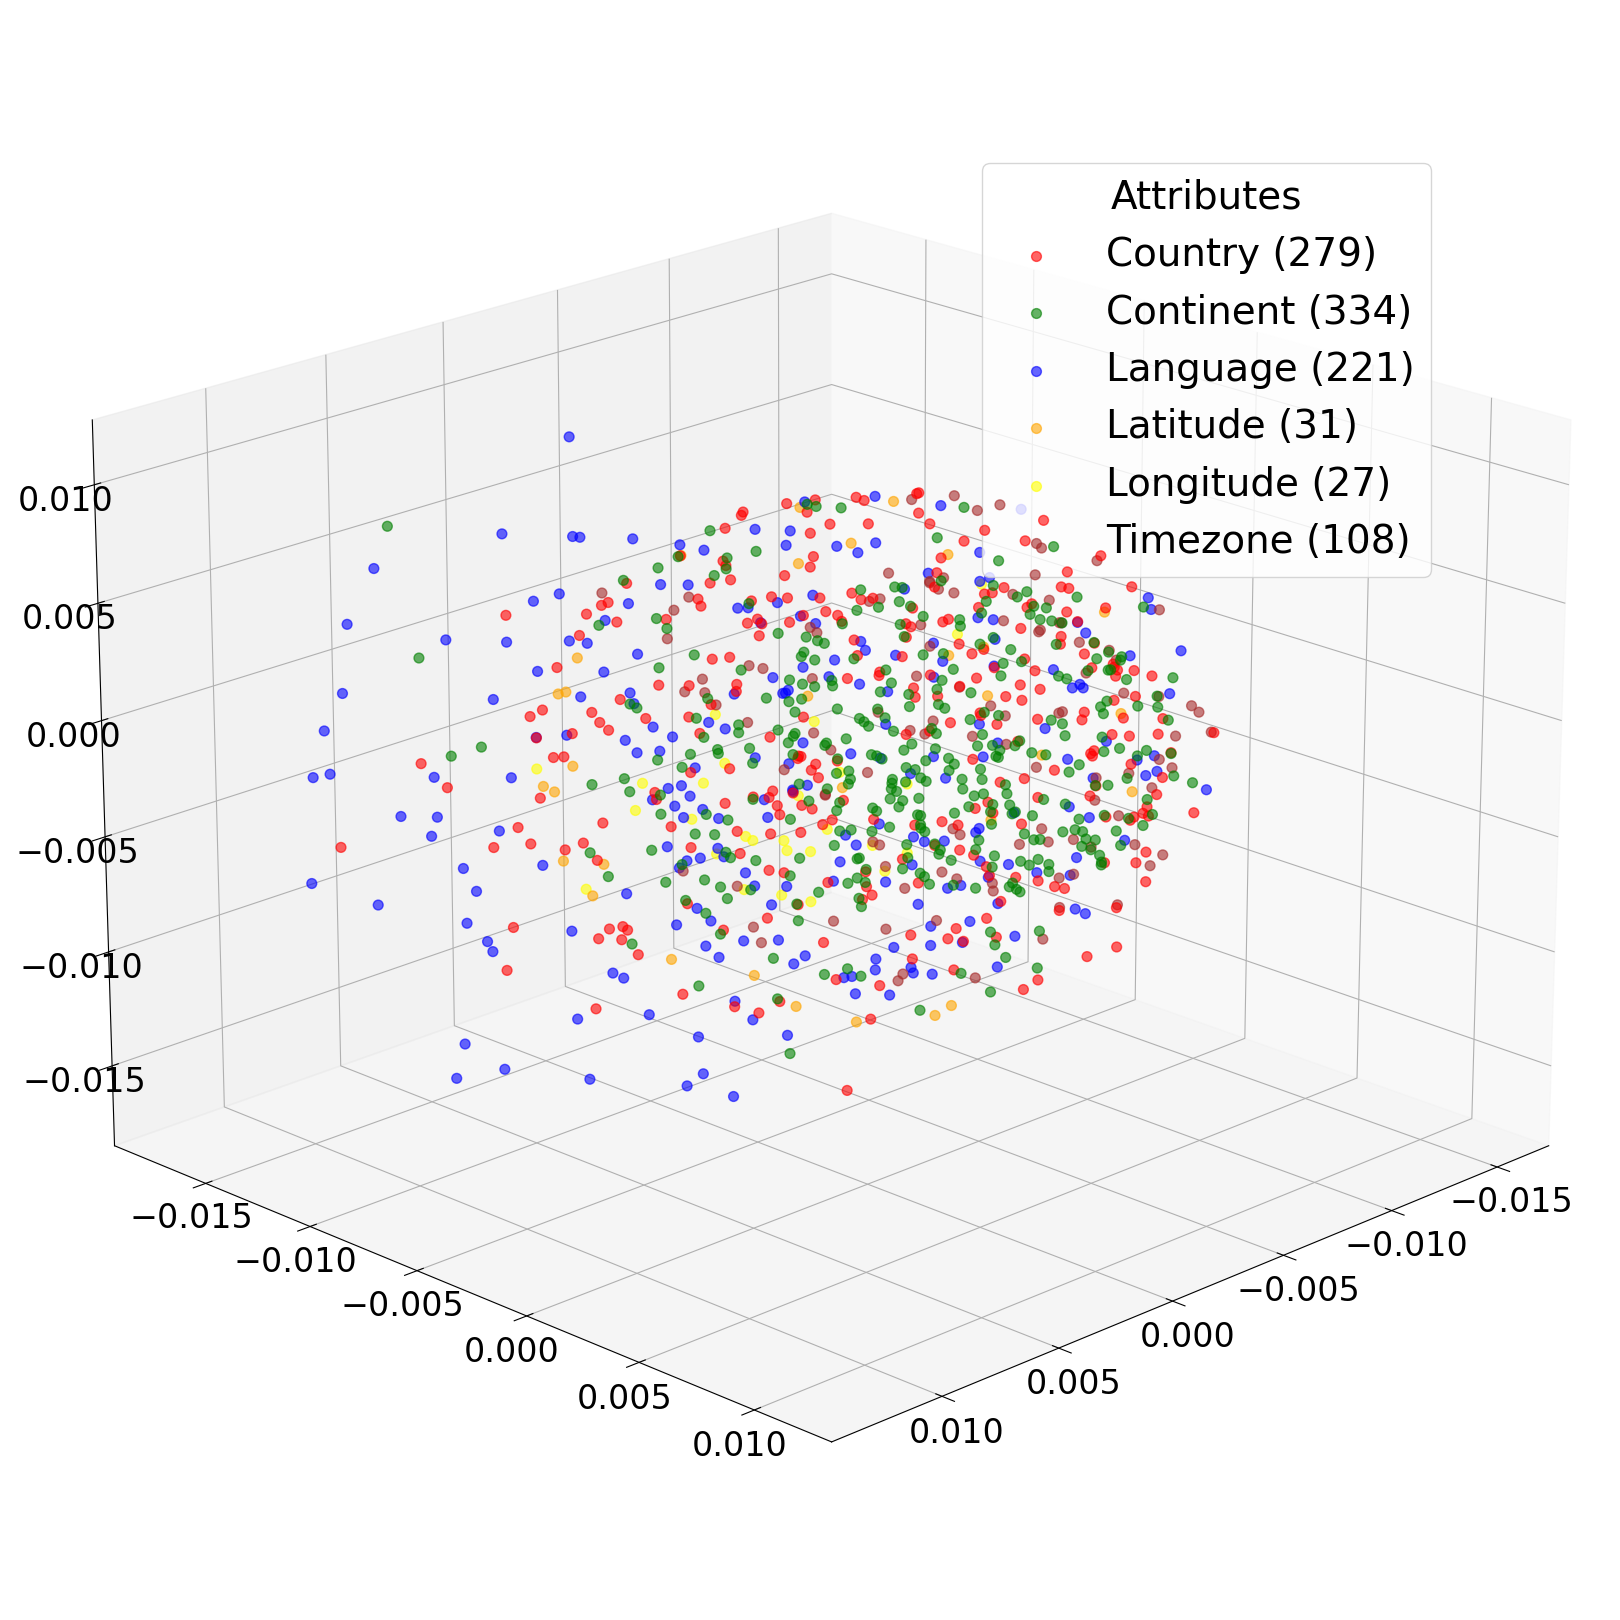

Adjusted Rand Index: 0.032
Adjusted Mutual Information: 0.080


In [17]:
import numpy as np
import torch
from sklearn.manifold import MDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

# When sampling the data
n_samples_total = basis_dataset_filtered.shape[0]
sample_size = 1000  # Adjust this number based on your needs
sample_indices = torch.randperm(n_samples_total)[:sample_size]
basis_sampled = basis_dataset_filtered[sample_indices]
labels_sampled = [labels[i] for i in sample_indices.cpu().numpy()]


def compute_distance_matrix_batched(basis_dataset_filtered, batch_size=250):
    n_samples = basis_dataset_filtered.shape[0]
    distance_matrix = torch.zeros(
        (n_samples, n_samples), device=basis_dataset_filtered.device
    )

    with tqdm(
        total=((n_samples + batch_size - 1) // batch_size) ** 2,
        desc="Computing distances",
    ) as pbar:
        for i in range(0, n_samples, batch_size):
            i_end = min(i + batch_size, n_samples)
            batch1 = basis_dataset_filtered[i:i_end]

            for j in range(i, n_samples, batch_size):  # Changed to start from i
                j_end = min(j + batch_size, n_samples)
                batch2 = basis_dataset_filtered[j:j_end]

                b1 = batch1.unsqueeze(1)
                b2 = batch2.unsqueeze(0)

                distances = compute_grassmann_distance_batch(
                    b1.expand(-1, j_end - j, -1, -1).reshape(-1, 32, 4096),
                    b2.expand(i_end - i, -1, -1, -1).reshape(-1, 32, 4096),
                ).reshape(i_end - i, j_end - j)

                # Fill both upper and lower triangles
                distance_matrix[i:i_end, j:j_end] = distances
                if i != j:  # Fill the symmetric part
                    distance_matrix[j:j_end, i:i_end] = distances.T

                pbar.update(1)

    # Ensure symmetry by averaging with transpose
    distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)

    return distance_matrix


# Use the sampled data for MDS and clustering
basis_sampled = basis_sampled.cuda()
distance_matrix = (
    compute_distance_matrix_batched(basis_sampled, batch_size=128).cpu().numpy()
)

# Apply MDS to get 3D embedding
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42, n_jobs=-1)
basis_embedded = mds.fit_transform(distance_matrix)

# Perform k-means clustering in the embedded space
n_clusters = 6  # Same as number of attributes
batch_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=1024,  # Larger batch size for faster processing
    n_init=3,  # Reduce number of initializations
    max_iter=100,
)
clusters = batch_kmeans.fit_predict(basis_embedded)

# Plotting
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")

colors = {
    "Country": "red",
    "Continent": "green",
    "Language": "blue",
    "Latitude": "orange",
    "Longitude": "yellow",
    "Timezone": "brown",
}

# Plot points colored by their true labels
for i, label in enumerate(colors.keys()):
    # Use labels_sampled instead of labels
    mask = np.array([lbl == label for lbl in labels_sampled])
    if np.any(mask):
        ax.scatter(
            basis_embedded[mask, 0],
            basis_embedded[mask, 1],
            basis_embedded[mask, 2],
            c=colors[label],
            label=f"{label} ({np.sum(mask)})",
            alpha=0.6,
            s=50,
        )

ax.legend(
    title="Attributes",
    fontsize=28,
    title_fontsize=28,
    loc="center right",
    bbox_to_anchor=(1 - 0.1, 1 - 0.225),
)

ax.view_init(elev=20, azim=45)
ax.tick_params(axis="both", which="major", labelsize=24)

plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05)
plt.show()

# Print clustering evaluation metrics
true_labels = np.array(
    [list(colors.keys()).index(lbl) for lbl in labels_sampled]
)  # Use labels_sampled instead of labels
print(f"Adjusted Rand Index: {adjusted_rand_score(true_labels, clusters):.3f}")
print(
    f"Adjusted Mutual Information: {adjusted_mutual_info_score(true_labels, clusters):.3f}"
)

In [18]:
classes = ["Country", "Continent", "Timezone", "Longitude", "Latitude", "Language"]

vector_dict = {}

for label in classes:
    label_idxs = [i for i in range(len(labels)) if labels[i] == label]
    vector_dict[label] = basis_dataset_filtered[label_idxs].cuda()

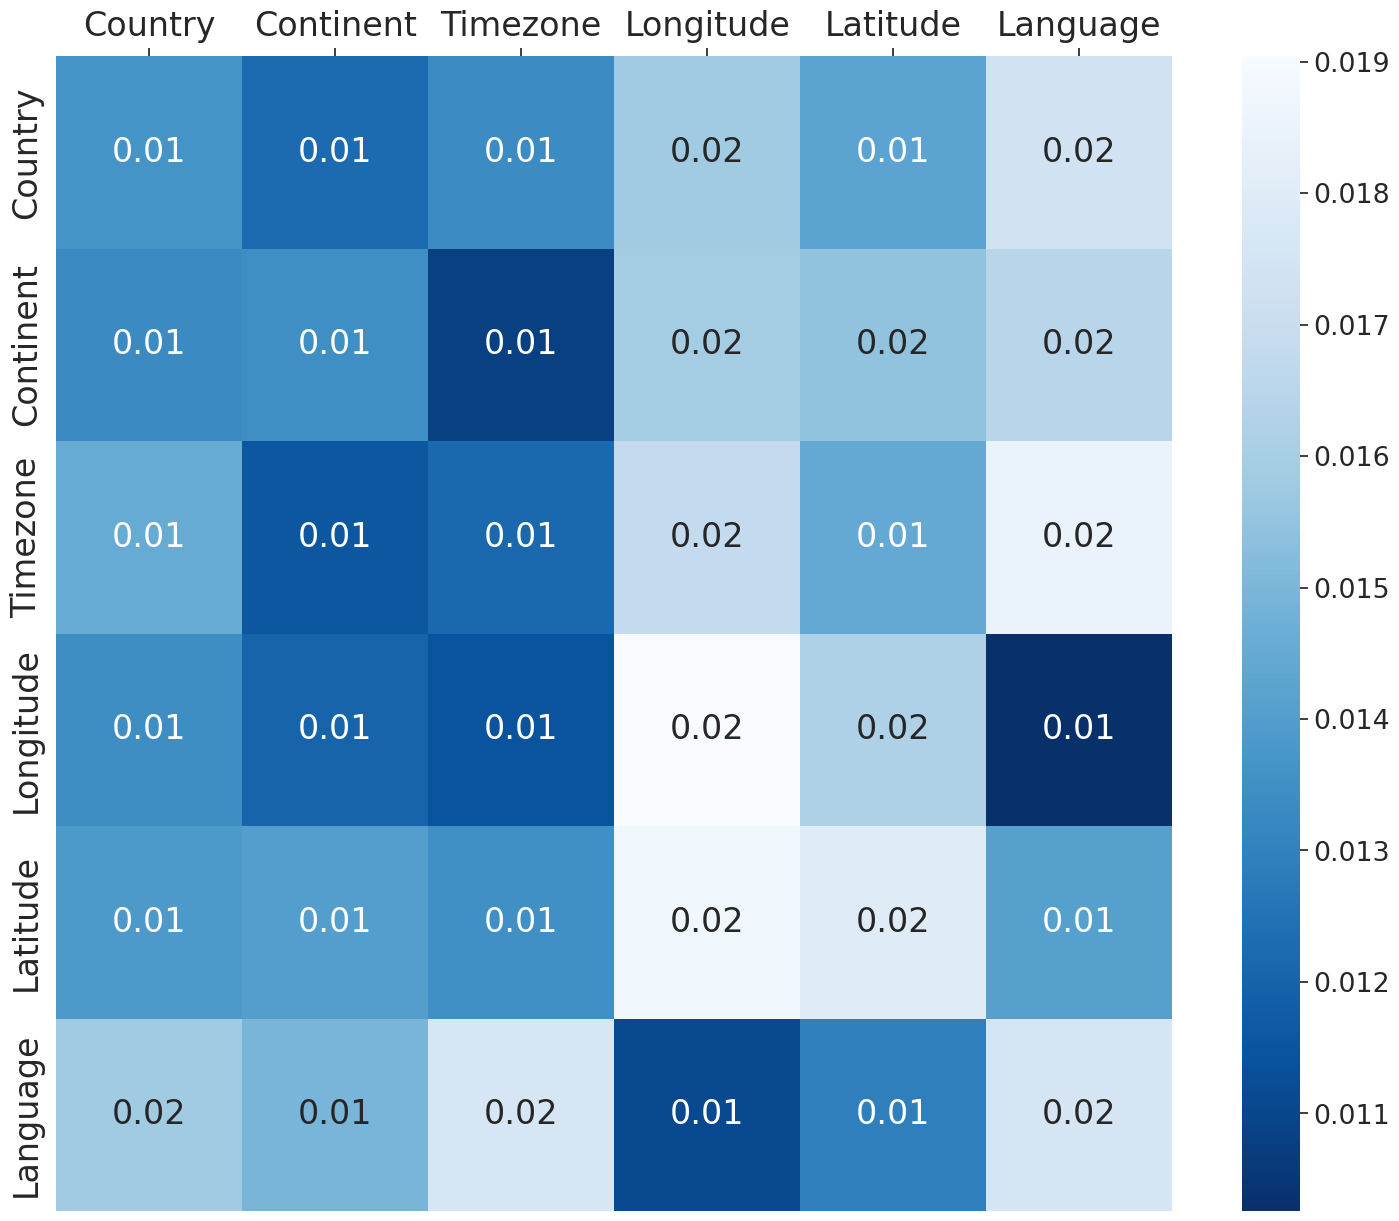

In [19]:
# For your pairwise similarity matrix calculation:
def compute_all_grassmann_distances_batched(vector_dict, batch_size=100):
    n_classes = len(vector_dict)
    grassmann_distances = torch.zeros((n_classes, n_classes))

    for i, (label1, vectors1) in enumerate(vector_dict.items()):
        for j, (label2, vectors2) in enumerate(vector_dict.items()):
            # Generate random indices for both sets of vectors
            idx1 = torch.randint(0, vectors1.shape[0], (batch_size,))
            idx2 = torch.randint(0, vectors2.shape[0], (batch_size,))

            # Get batches
            batch1 = vectors1[idx1]  # (batch_size, 32, 4096)
            batch2 = vectors2[idx2]  # (batch_size, 32, 4096)

            # Compute distances for entire batch at once
            distances = compute_grassmann_distance_batch(batch1, batch2)

            # Store mean distance
            grassmann_distances[i, j] = distances.mean()

    return grassmann_distances


# Usage for your heatmap code:
n_samples = 256  # batch size
grassmann_distances = compute_all_grassmann_distances_batched(
    vector_dict, batch_size=n_samples
)

# Rest of your plotting code remains the same
sns.set(style="whitegrid", font_scale=1.75)
fig, ax = plt.subplots(figsize=(18, 15))

sns.heatmap(
    grassmann_distances,
    annot=True,
    cmap="Blues_r",
    xticklabels=vector_dict.keys(),
    yticklabels=vector_dict.keys(),
    ax=ax,
    fmt=".2f",
)

ax.tick_params(axis="both", which="major", labelsize=24)
for text in ax.texts:
    text.set_fontsize(24)

plt.gca().xaxis.tick_top()
fig.savefig("hyperdas_grassmann_distance.pdf")
plt.show()